In [1]:
!pip install transformers

In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [3]:
#@title import packages

import torch
import numpy as np
import pandas as pd
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans

import torch.nn as nn

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Normalize, Resize, Compose, ToPILImage

In [4]:
#@title Plotting functions

import argparse
import torch
import matplotlib.pyplot as plt
import torchvision.transforms
from torch import nn
from torchvision import transforms
import torch.nn.modules.utils as nn_utils
import math
#import timm
import types
from pathlib import Path
from typing import Union, List, Tuple
from PIL import Image
from matplotlib.colors import ListedColormap

def imsc(img, *args, quiet=False, lim=None, interpolation='lanczos', **kwargs):
    r"""Rescale and displays an image represented as a img.
    The function scales the img :attr:`im` to the [0 ,1] range.
    The img is assumed to have shape :math:`3\times H\times W` (RGB)
    :math:`1\times H\times W` (grayscale).
    Args:
        img (:class:`torch.Tensor` or :class:`PIL.Image`): image.
        quiet (bool, optional): if False, do not display image.
            Default: ``False``.
        lim (list, optional): maximum and minimum intensity value for
            rescaling. Default: ``None``.
        interpolation (str, optional): The interpolation mode to use with
            :func:`matplotlib.pyplot.imshow` (e.g. ``'lanczos'`` or
            ``'nearest'``). Default: ``'lanczos'``.
    Returns:
        :class:`torch.Tensor`: Rescaled image img.
    """
    if isinstance(img, Image.Image):
        img = pil_to_tensor(img)
    handle = None
    with torch.no_grad():
        if not lim:
            lim = [img.min(), img.max()]
        img = img - lim[0]  # also makes a copy
        img.mul_(1 / (lim[1] - lim[0]))
        img = torch.clamp(img, min=0, max=1)
        if not quiet:
            bitmap = img.expand(3,
                                *img.shape[1:]).permute(1, 2, 0).cpu().numpy()
    return bitmap

def draw_correspondences(points1: List[Tuple[float, float]], points2: List[Tuple[float, float]],
                         image1: Image.Image, image2: Image.Image) -> Tuple[plt.Figure, plt.Figure]:
    """
    draw point correspondences on images.
    :param points1: a list of (y, x) coordinates of image1, corresponding to points2.
    :param points2: a list of (y, x) coordinates of image2, corresponding to points1.
    :param image1: a PIL image.
    :param image2: a PIL image.
    :return: two figures of images with marked points.
    """
    assert len(points1) == len(points2), f"points lengths are incompatible: {len(points1)} != {len(points2)}."
    num_points = len(points1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    ax1.axis('off')
    ax2.axis('off')
    #ax1.imshow(image1)
    #ax2.imshow(image2)
    ax1.imshow(imsc(image1))
    ax2.imshow(imsc(image2))

    if not points1:
      return fig

    if num_points > 15:
        cmap = plt.get_cmap('tab10')
    else:
        cmap = ListedColormap(["red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
                               "maroon", "black", "white", "chocolate", "gray", "blueviolet"])
    colors = np.array([cmap(x) for x in range(num_points)])
    radius1, radius2 = 8, 1
    for point1, point2, color in zip(points1, points2, colors):
        y1, x1 = point1
        circ1_1 = plt.Circle((x1, y1), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ1_2 = plt.Circle((x1, y1), radius2, facecolor=color, edgecolor='white')
        ax1.add_patch(circ1_1)
        ax1.add_patch(circ1_2)
        y2, x2 = point2
        circ2_1 = plt.Circle((x2, y2), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ2_2 = plt.Circle((x2, y2), radius2, facecolor=color, edgecolor='white')
        ax2.add_patch(circ2_1)
        ax2.add_patch(circ2_2)
    return fig

In [5]:
#@title create dataset


target_mean = [0.485, 0.456, 0.406]
target_std = [0.229, 0.224, 0.225]
processor = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=target_mean, std=target_std)])

class CUB(Dataset):
    def __init__(self, base_path, train=True):

        self.base_path = base_path

        self.labels = pd.read_csv(''.join([base_path, 'image_class_labels.txt']), header=None, sep=" ", names=["id", "label"])
        self.train_test_split = pd.read_csv(''.join([base_path, 'train_test_split.txt']), header=None, sep=" ", names=["id", "is_train"])
        self.filenames = pd.read_csv(''.join([base_path, 'images.txt']), header=None, sep=" ")
        # self.segmentation_path = 'drive/MyDrive/CoSegXAI/datasets/cub200/segmentations/'
        self.segmentation_path = '/mnt/d/Github/SuperpixelCUB/CUB_200_data/segmentations/'

        self.transforms = Compose([
                ToTensor(),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])

        if train:
          mask = self.train_test_split.is_train.values == 1
        else:
          mask = self.train_test_split.is_train.values == 0

        self.filenames = self.filenames.iloc[mask]
        self.labels = self.labels[mask]

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, index):

        y = self.labels.iloc[index, 1] - 1
        file_name = self.filenames.iloc[index, 1]

        mask = np.array(Image.open(''.join([self.segmentation_path, file_name.split('.')[0], '.', file_name.split('.')[1], '.png'])).resize((224, 224)))

        x = Image.open(''.join([self.base_path, 'images/', file_name])).convert('RGB')
        x = processor(x)

        return x, y, (mask >= 1.0) * np.ones_like(mask)


class Prototype_Dataset(Dataset):
    def __init__(self, base_path, file_names, labels, train=True):

        self.base_path = base_path

        self.labels = labels
        self.file_names = file_names
        # self.segmentation_path = 'drive/MyDrive/CoSegXAI/datasets/cub200/segmentations/'
        self.segmentation_path = '/mnt/d/Github/SuperpixelCUB/CUB_200_data/segmentations/'

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):

        y = self.labels[index]
        file_name = self.file_names[index]

        mask = np.array(Image.open(''.join([self.segmentation_path, file_name.split('.')[0], '.', file_name.split('.')[1], '.png'])).resize((224, 224)))

        x = Image.open(''.join([self.base_path, 'images/', file_name])).convert('RGB')
        x = processor(x)

        return x, y, (mask >= 1.0) * np.ones_like(mask)


21


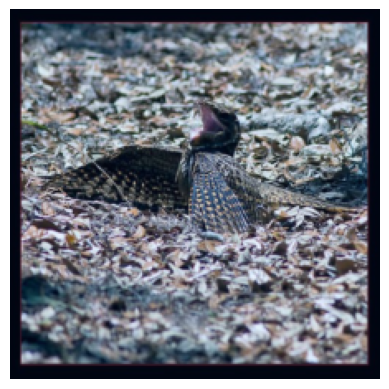

In [6]:
#@title dataset and dataloader and load a random query from test set

import random

# base_path = 'drive/MyDrive/CoSegXAI/datasets/cub200/CUB_200_2011/CUB_200_2011/'
base_path = '/mnt/d/Github/SuperpixelCUB/CUB_200_data/CUB_200_2011/'

test_dataset = CUB(base_path, train=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)

random.seed(123423)
data_indices = random.sample(range(test_dataset.__len__()), 1)

#data_indices = [205]

for counter, data_idx in enumerate(data_indices):

  query, query_label, query_mask = test_dataset.__getitem__(data_idx)
  print(query_label)

plt.figure(1)
plt.imshow(imsc(query))
plt.axis('off')
plt.show()


In [7]:
#@title load model and precomputed prototypes

from transformers import CLIPVisionModel, Dinov2Model, ViTMAEModel, ViTModel

#model = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14").to('cuda')
model = Dinov2Model.from_pretrained("facebook/dinov2-base").to('cuda')
#model = ViTMAEModel.from_pretrained("facebook/vit-mae-large", attn_implementation="eager").to('cuda')
#model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k", attn_implementation="eager").to('cuda')

# all_prototype_file_names = pd.read_csv('drive/MyDrive/CoSegXAI/dinov2_vitb14_5_prototypes_file_names.csv')['0'].values
# all_prototype_labels = pd.read_csv('drive/MyDrive/CoSegXAI/dinov2_vitb14_5_prototypes_labels.csv')['0'].values
# all_prototype_clf_tokens = torch.load('drive/MyDrive/CoSegXAI/dinov2_vitb14_5_prototypes_representation.pth').to('cuda')
df = pd.read_csv('/mnt/d/Github/SuperpixelCUB/csv_data/dinov2_vitb14_5_prototypes_file_names.csv')
print(df.columns)
all_prototype_file_names = df.columns.tolist()
all_prototype_labels = pd.read_csv('/mnt/d/Github/SuperpixelCUB/csv_data/dinov2_vitb14_5_prototypes_labels.csv')['0'].values
all_prototype_clf_tokens = torch.load('/mnt/d/Github/SuperpixelCUB/csv_data/dinov2_vitb14_5_prototypes_representation.pth').to('cuda')

IMG_SIZE = 224
STRIDE = model.config.patch_size #model.get_submodule('embeddings').get_submodule('patch_embeddings').get_submodule('projection').stride[0]
PATCH_SIZE = model.config.patch_size
NUMBER_OF_PATCHES_X = NUMBER_OF_PATCHES_Y = int(IMG_SIZE / PATCH_SIZE)
LATENT_DIM = all_prototype_clf_tokens.shape[-1]

/home/chensy/anaconda3/envs/vlpart_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Index(['001.Black_footed_Albatross/Black_Footed_Albatross_0056_796078.jpg',
       '001.Black_footed_Albatross/Black_Footed_Albatross_0014_89.jpg',
       '001.Black_footed_Albatross/Black_Footed_Albatross_0081_426.jpg',
       '001.Black_footed_Albatross/Black_Footed_Albatross_0067_170.jpg',
       '001.Black_footed_Albatross/Black_Footed_Albatross_0040_796066.jpg',
       '002.Laysan_Albatross/Laysan_Albatross_0005_565.jpg',
       '002.Laysan_Albatross/Laysan_Albatross_0081_800.jpg',
       '002.Laysan_Albatross/Laysan_Albatross_0076_671.jpg',
       '002.Laysan_Albatross/Laysan_Albatross_0083_756.jpg',
       '002.Laysan_Albatross/Laysan_Albatross_0061_563.jpg',
       ...
       '199.Winter_Wren/Winter_Wren_0081_190049.jpg',
       '199.Winter_Wren/Winter_Wren_0051_189990.jpg',
       '199.Winter_Wren/Winter_Wren_0109_189850.jpg',
       '199.Winter_Wren/Winter_Wren_0072_189521.jpg',
       '199.Winter_Wren/Winter_Wren_0130_189531.jpg',
       '200.Common_Yellowthroat/Common_Yello

/tmp/ipykernel_1848/49670112.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_prototype_clf_tokens = torch.load('/mnt/d/Github/SuperpixelCUB/csv_data/dinov2_vitb14_5

In [8]:
#@title find closest prototypes

from torch.nn.functional import cosine_similarity

device = 'cuda'
NUMBER_OF_PROTOTYPES = 5

def get_k_closest_prototypes(model, query, prototype_clf_tokens):

    query_clf_token = model(query).pooler_output
    similarity = cosine_similarity(query_clf_token, prototype_clf_tokens)
    top_k_similar_prototypes_indices = torch.topk(similarity, NUMBER_OF_PROTOTYPES)[1]

    return [i.item() for i in top_k_similar_prototypes_indices]

def get_tokens(model, query):
    return model(query).last_hidden_state[:, 1:, :].numpy(force=True)

def get_prototype_tokens(top_k_indices, prototype_file_names, prototype_labels, model):

    top_k_prototypes = [prototype_file_names[i] for i in top_k_indices]
    top_k_labels = [prototype_labels[i] for i in top_k_indices]

    prototype_dataset = Prototype_Dataset(base_path, top_k_prototypes, top_k_labels)
    prototype_loader = DataLoader(prototype_dataset, batch_size=len(top_k_labels), shuffle=False, num_workers=0)
    prototypes, labels, masks = next(iter(prototype_loader))
    prototypes = prototypes.to(device)

    tokens = get_tokens(model, prototypes.to(device))

    return tokens, prototypes, labels, masks.numpy(force=True)

indices_of_k_closest_prototypes = get_k_closest_prototypes(model, query.to(device).unsqueeze(0), all_prototype_clf_tokens)
prototype_tokens, prototypes, prototype_labels, prototype_masks = get_prototype_tokens(indices_of_k_closest_prototypes, all_prototype_file_names, all_prototype_labels, model)


In [9]:
#@title functions for getting segments, segment representations, and keypoints in image

from skimage.segmentation import slic, expand_labels
from skimage.transform import resize
from skimage.measure import regionprops

def get_segments(embedding, mask, number_of_patches: int,
                 resize_size: int = 64, number_of_segments: int = 8):

    embedding = embedding.reshape(number_of_patches, number_of_patches, -1)
    embedding = resize(embedding, (resize_size, resize_size))

    mask = resize(mask, (resize_size, resize_size), order=0)

    segments = slic(embedding, n_segments=number_of_segments, mask=mask)
    #segments = slic(embedding, n_segments=12, compactness=0.01, mask=mask, min_size_factor=0.1)

    return segments

def get_segment_representation(segments, embedding, number_of_patches: int,
                               latent_dimensionality: int, resize_size: int = 64):

    segment_representations = []

    embedding = embedding.reshape(number_of_patches, number_of_patches, -1)
    embedding = resize(embedding, (resize_size, resize_size)).reshape(-1, latent_dimensionality)

    for segment_i in np.unique(segments)[1:]:
        segment_i_indices = np.where(segments.flatten()==segment_i)[0]
        segment_representations.append(np.mean(embedding[segment_i_indices], 0, keepdims=True))

    return np.concatenate(segment_representations), len(np.unique(segments)[1:])


def get_keypoints(segments, resize_size: int = 64, image_size: int = 224):

    low_res_keypoints = np.zeros_like(segments)
    low_res_segments_properties = regionprops(segments)

    for segment_i, properties_i in enumerate(low_res_segments_properties):
        x_coordinate, y_coordinate = np.int32(np.round(properties_i.centroid))
        low_res_keypoints[x_coordinate, y_coordinate] = segment_i+1

    keypoints = np.zeros((image_size, image_size), dtype=np.int32)

    high_res_keypoints = resize(low_res_keypoints, (image_size, image_size), order=0)
    segments_properties = regionprops(high_res_keypoints)

    for segment_i, properties_i in enumerate(segments_properties):
        x_coordinate, y_coordinate = np.int32(np.round(properties_i.centroid))
        keypoints[x_coordinate, y_coordinate] = segment_i+1

    return keypoints

In [10]:
#@title find all keypoints in each image and mean representations

all_keypoints = []
all_segments = []
all_segments_representation = []
number_of_segments = []

embeddings = np.concatenate((get_tokens(model, query.to(device).unsqueeze(0)), prototype_tokens))
masks = np.concatenate((query_mask[None, :, :], prototype_masks))

for embedding, mask in zip(embeddings, masks):
    all_segments.append(get_segments(embedding, mask, NUMBER_OF_PATCHES_X))

for segment, embedding in zip(all_segments, embeddings):
    segments_representation, number_of_segments_i = get_segment_representation(segment, embedding, NUMBER_OF_PATCHES_X, LATENT_DIM)
    all_segments_representation.append(segments_representation)
    number_of_segments.append(number_of_segments_i)

segment_sum = 0
for image_counter, segment_i in enumerate(all_segments):
    if image_counter == 0:
        keypoints_i = get_keypoints(segment_i)
    elif image_counter == 1:
        keypoints_i = get_keypoints(segment_i)
        keypoints_i += (segment_sum*(keypoints_i>0))
        segment_sum += all_segments[image_counter].max()
    else:
        keypoints_i = get_keypoints(segment_i)
        keypoints_i += (segment_sum*(keypoints_i>0))
        segment_sum += all_segments[image_counter].max()

    all_keypoints.append(keypoints_i)


In [11]:
#@title function for getting mutual nns

def get_mutual_nns(representations: torch.Tensor, number_of_segments: List):

    query_representation = representations[0]
    prototype_representations = np.concatenate(representations[1:])

    nearest_neighbor_query, distances_query = pairwise_distances_argmin_min(query_representation, prototype_representations, axis=1, metric='cosine')
    nearest_neighbor_prototypes, distances_prototype = pairwise_distances_argmin_min(query_representation, prototype_representations, axis=0, metric='cosine')

    best_buddies_query = nearest_neighbor_prototypes[nearest_neighbor_query] == np.arange(number_of_segments[0])
    best_buddies_prototypes = nearest_neighbor_query[nearest_neighbor_prototypes] == np.arange(np.sum(number_of_segments[1:]))

    best_buddies_query_indices = nearest_neighbor_query[best_buddies_query]
    best_buddies_prototypes_indices = nearest_neighbor_prototypes[best_buddies_prototypes]

    return best_buddies_query, best_buddies_prototypes, nearest_neighbor_query, nearest_neighbor_prototypes

In [12]:
#@title find mutual nns

best_buddies_query, best_buddies_prototypes, nearest_neighbor_query, nearest_neighbor_prototypes = get_mutual_nns(all_segments_representation, number_of_segments)

best_buddies_query_indices = nearest_neighbor_query[best_buddies_query]
best_buddies_prototypes_indices = nearest_neighbor_prototypes[best_buddies_query_indices]

all_keypoints = np.array(all_keypoints)
all_bb_keypoints = np.zeros_like(np.array(all_keypoints))

for counter, (bb_query_idx, bb_proto_idx) in enumerate(zip(best_buddies_query_indices, best_buddies_prototypes_indices)):

    y_coordinate_q, x_coordinate_q = np.where(all_keypoints[0]==bb_proto_idx+1)
    proto_idx, y_coordinate_p, x_coordinate_p= np.where(all_keypoints[1:]==bb_query_idx+1)

    all_bb_keypoints[0, y_coordinate_q, x_coordinate_q] = counter+1
    all_bb_keypoints[proto_idx+1, y_coordinate_p, x_coordinate_p] = counter+1


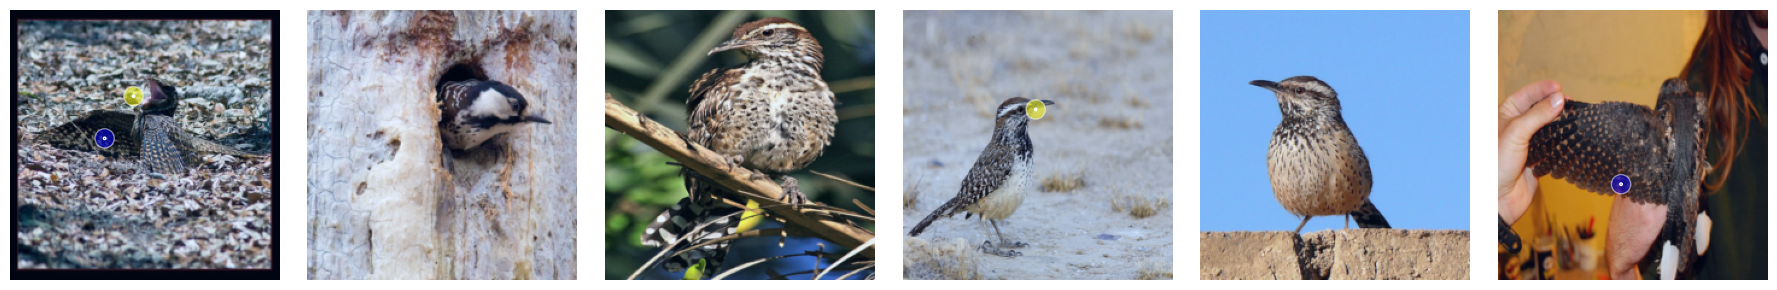

In [13]:
#@title plot matching keypoints


color_names = ["red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
                    "maroon", "black", "white", "chocolate", "gray", "blueviolet"]
cmap = ListedColormap(color_names)

colors = np.array([cmap(x) for x in range(15)])

fig, axs = plt.subplots(1, NUMBER_OF_PROTOTYPES+1, figsize=(18, 3))

inputs = torch.cat([query.to(device).unsqueeze(0), prototypes])

radius1, radius2 = 8, 1

for col_idx, image_i in enumerate(inputs):

    axs[col_idx].imshow(imsc(image_i))
    axs[col_idx].set_axis_off()

for keypoint_i in np.unique(all_bb_keypoints)[1:]:

    y_coordinates_q, x_coordinates_q = np.where(all_bb_keypoints[0] == keypoint_i)

    circ1_1 = plt.Circle((x_coordinates_q, y_coordinates_q), radius1, facecolor=colors[keypoint_i], edgecolor='white', alpha=0.5)
    circ1_2 = plt.Circle((x_coordinates_q, y_coordinates_q), radius2, facecolor=colors[keypoint_i], edgecolor='white')
    axs[0].add_patch(circ1_1)
    axs[0].add_patch(circ1_2)

    proto_idx, y_coordinates_p, x_coordinates_p = np.where(all_bb_keypoints[1:] == keypoint_i)

    circ1_1 = plt.Circle((x_coordinates_p, y_coordinates_p), radius1, facecolor=colors[keypoint_i], edgecolor='white', alpha=0.5)
    circ1_2 = plt.Circle((x_coordinates_p, y_coordinates_p), radius2, facecolor=colors[keypoint_i], edgecolor='white')
    axs[proto_idx[0]+1].add_patch(circ1_1)
    axs[proto_idx[0]+1].add_patch(circ1_2)

fig.tight_layout()

[559]
104 105 105.Whip_poor_Will
21 22 022.Chuck_will_Widow


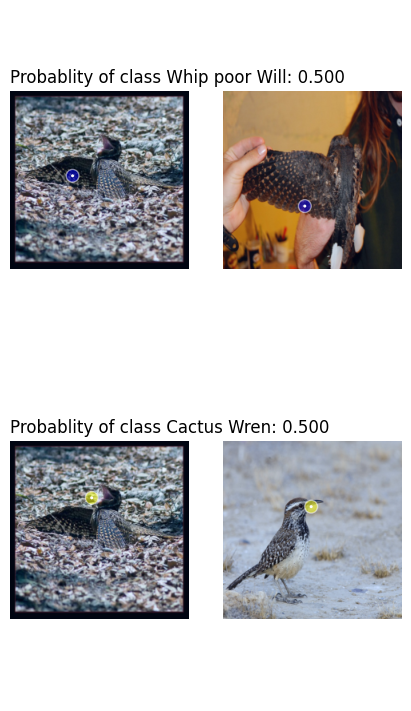

In [14]:
#@title plot explanation

from operator import itemgetter
from collections import OrderedDict

def del_zero_keys(input_dict):
    del_keys= []
    for key, value in input_dict.items():
        if value == 0:
            del_keys.append(key)
    for key in del_keys:
        input_dict.pop(key)
    return input_dict

class_names = pd.read_csv(base_path+'/classes.txt', header=None)[0].values
color_names = ["red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
                    "maroon", "black", "white", "chocolate", "gray", "blueviolet"]
cmap = ListedColormap(color_names)

colors = np.array([cmap(x) for x in range(15)])

number_of_keypoints_in_image = {key: 0 for key in range(NUMBER_OF_PROTOTYPES)}

for keypoint_i in np.unique(all_bb_keypoints)[1:]:
    proto_idx, _, _ = np.where(all_bb_keypoints[1:] == keypoint_i)
    number_of_keypoints_in_image[proto_idx[0]] += 1

predictions = {}
active_images_per_class = {}

unique_labels, label_counts = torch.unique(prototype_labels, return_counts=True)

active_images = {key.item(): 0 for key in unique_labels}
active_images_per_class = {key.item(): 0 for key in unique_labels}
keypoints_per_class = {key.item(): 0 for key in unique_labels}

for label_i in torch.unique(prototype_labels):
    label_indices = np.where(label_i == prototype_labels)[0]

    for label_idx in label_indices:
        keypoints_per_class[label_i.item()] += number_of_keypoints_in_image[label_idx]

        if number_of_keypoints_in_image[label_idx] > 0:
          active_images_per_class[label_i.item()] += 1

del_keys= []
for key, value in active_images_per_class.items():
    if value == 0:
        del_keys.append(key)
for key in del_keys:
    active_images_per_class.pop(key)

prediction = max(keypoints_per_class, key=keypoints_per_class.get)

active_images_per_class = del_zero_keys(active_images_per_class)
keypoints_per_class = del_zero_keys(keypoints_per_class)

keypoints_per_class = OrderedDict(sorted(keypoints_per_class.items(), key=itemgetter(1), reverse=True))

number_of_columns = active_images_per_class[max(active_images_per_class, key=active_images_per_class.get)]
number_of_rows = len(active_images_per_class)

width_ratios = [1.0 for row_i in range(number_of_columns+1)]
width_ratios.insert(1, 0.1)

fig, axs = plt.subplots(number_of_rows, number_of_columns+2,
                        layout='constrained', squeeze=False, figsize=(4.0 * number_of_columns, 3.5 * number_of_rows),
                        gridspec_kw={'width_ratios': width_ratios})
active_prototype_dict = {}

for ax in axs.ravel(): ax.set_axis_off()

inputs = torch.cat([query.to(device).unsqueeze(0), prototypes])
total_number_of_keypoints = sum(keypoints_per_class.values())

for row_i, label_i in enumerate(keypoints_per_class):

    class_name = ' '.join(class_names[label_i].split('.')[-1].split('_'))

    probability_of_class = keypoints_per_class[label_i] / total_number_of_keypoints

    axs[row_i, 0].imshow(imsc(inputs[0]))
    axs[row_i, 0].set_title(f"Probablity of class {class_name}: {probability_of_class:.3f}", loc='left')

    class_indices = list(np.where((prototype_labels == label_i))[0])

    zero_image_counter = 0
    for counter, class_idx_i in enumerate(class_indices):

        active_prototype_dict[class_idx_i] = counter - zero_image_counter

        if number_of_keypoints_in_image[class_idx_i] > 0:
            axs[row_i, counter+2-zero_image_counter].imshow(imsc(inputs[class_idx_i+1]))
        else:
            zero_image_counter += 1

radius1, radius2 = 8, 1
array_of_keys = np.array(list(keypoints_per_class.keys()))

print(data_indices)
print(prediction, class_names[prediction])
print(query_label, class_names[query_label])

for keypoint_i in np.unique(all_bb_keypoints)[1:]:

    y_coordinates_q, x_coordinates_q = np.where(all_bb_keypoints[0] == keypoint_i)
    proto_idx, y_coordinates_p, x_coordinates_p = np.where(all_bb_keypoints[1:] == keypoint_i)

    keypoint_label = prototype_labels[proto_idx].item()
    row_of_keypoint = np.where(array_of_keys == keypoint_label)[0]
    col_of_proto_keypoint = active_prototype_dict[proto_idx[0]]

    circ1_1 = plt.Circle((x_coordinates_q, y_coordinates_q), radius1, facecolor=colors[keypoint_i], edgecolor='white', alpha=0.5)
    circ1_2 = plt.Circle((x_coordinates_q, y_coordinates_q), radius2, facecolor=colors[keypoint_i], edgecolor='white')
    axs[row_of_keypoint[0], 0].add_patch(circ1_1)
    axs[row_of_keypoint[0], 0].add_patch(circ1_2)

    circ1_1 = plt.Circle((x_coordinates_p, y_coordinates_p), radius1, facecolor=colors[keypoint_i], edgecolor='white', alpha=0.5)
    circ1_2 = plt.Circle((x_coordinates_p, y_coordinates_p), radius2, facecolor=colors[keypoint_i], edgecolor='white')
    axs[row_of_keypoint[0], col_of_proto_keypoint+2].add_patch(circ1_1)
    axs[row_of_keypoint[0], col_of_proto_keypoint+2].add_patch(circ1_2)

#plt.savefig(f"kcc_{data_indices[0]}_{np.int32(prediction==query_label)}.png", dpi=300)

In [ ]:
raise

RuntimeError: No active exception to reraise

In [15]:
#@title function for making prediction

def get_prediction(prototype_matches, prototype_labels, number_of_segments: List, number_of_prototypes: int = 5):

    number_of_matches = []

    for number_of_segments_index in range(len(number_of_segments)-1):
        lower_bound = np.int32(np.sum(number_of_segments[:number_of_segments_index]))
        upper_bound = np.int32(np.sum(number_of_segments[:(number_of_segments_index+1)]))
        number_of_matches.append(np.sum(prototype_matches[lower_bound:upper_bound]))

    number_of_matches = np.array(number_of_matches)
    total_number_of_matches = np.sum(number_of_matches)
    predictions = {}
    prototypes_per_class = {}

    unique_labels, label_counts = torch.unique(prototype_labels, return_counts=True)

    for label_i in torch.unique(prototype_labels):
        label_indices = np.where(label_i == prototype_labels)[0]

        if np.sum(number_of_matches[label_indices]) == 0: continue

        predictions[label_i.item()] = np.sum(number_of_matches[label_indices]) / total_number_of_matches
        prototypes_per_class[label_i.item()] = len(label_indices)

    return predictions, prototypes_per_class

predictions, prototypes_per_class = get_prediction(best_buddies_prototypes, prototype_labels, number_of_segments)
print(prototypes_per_class)
prediction = max(predictions, key=predictions.get)
print(predictions, prediction)

{104: 1, 193: 3}
{104: np.float64(0.5), 193: np.float64(0.5)} 104


In [16]:
labels_with_matches = {label_i.item():0 for label_i in torch.unique(prototype_labels)}
number_of_label_matches = {label_i.item():0 for label_i in torch.unique(prototype_labels)}
prototypes_with_matches = {}

for prototype_count, (keypoints_i, prototype_label) in enumerate(zip(all_keypoints[1:], prototype_labels)):
    number_of_matches = 0
    for keypoint_i in np.unique(keypoints_i)[1:]:

        if prototype_count == 0:
          if not best_buddies_prototypes[keypoint_i-1]: continue
        else:
          if not best_buddies_prototypes[np.sum(number_of_segments[:(prototype_count)])+keypoint_i-1]: continue

        labels_with_matches[prototype_label.item()] += 1
        number_of_matches += 1

        if number_of_matches > 0:
          number_of_label_matches[prototype_label.item()] += 1

    if number_of_matches > 0:
      prototypes_with_matches[prototype_count] = 1

total_number_of_matches = sum(labels_with_matches.values())
labels_with_matches = {k: v for k, v in sorted(labels_with_matches.items(), key=lambda item: item[1], reverse=True)}

zero_labels = []
for label, number_of_matches in labels_with_matches.items():
    if number_of_matches == 0:
        zero_labels.append(label)

for zero_label in zero_labels:
  labels_with_matches.pop(zero_label)


print(total_number_of_matches)
print(labels_with_matches)
print(prototypes_with_matches)
print(number_of_label_matches)

IndexError: index 51 is out of bounds for axis 0 with size 42

In [ ]:

number_of_rows = len(labels_with_matches)
number_of_columns = prototypes_per_class[max(prototypes_per_class, key=prototypes_per_class.get)]+1


fig, axs = plt.subplots(nrows = number_of_rows, ncols = number_of_columns,
                        layout='constrained', squeeze=False, figsize=(3.5 * number_of_columns, 3.5 * number_of_rows))

#axs[0, 0].set_title('Query')
for ax in axs.ravel(): ax.set_axis_off()

for row_idx, label_i in enumerate(labels_with_matches.keys()):

    axs[row_idx, 0].imshow(imsc(inputs[0]))

    indices_of_labels = list(np.where((prototype_labels == label_i))[0])

    for label_index in indices_of_labels:
        if not label_index in list(prototypes_with_matches.keys()):
            indices_of_labels.remove(label_index)

    indices_of_labels = [index_of_label+1 for index_of_label in indices_of_labels]

    span_of_indices_of_lables = []
    for index_of_label in indices_of_labels:
        upper_bound = np.sum(number_of_segments[:(index_of_label)])
        lower_bound = upper_bound-np.sum(number_of_segments[(index_of_label-1):(index_of_label)])

        for i in range(lower_bound, upper_bound):
            span_of_indices_of_lables.append(i)

    indices_of_labels.insert(0, 0)

    all_keypoints_row_i = [all_keypoints[i] for i in indices_of_labels]

    for col_idx, (index_of_label, keypoints_i) in enumerate(zip(indices_of_labels, all_keypoints_row_i)):

        axs[row_idx, col_idx].imshow(imsc(inputs[index_of_label]))
        axs[row_idx, col_idx].set_axis_off()

        radius1, radius2 = 8, 1

        for keypoint_counter, keypoint_i in enumerate(np.unique(keypoints_i)[1:]):

            if index_of_label == 0:
              if not best_buddies_query[keypoint_i-1]: continue
            elif index_of_label == 1:
              if not best_buddies_prototypes[keypoint_i-1]: continue
            else:
              if not best_buddies_prototypes[np.sum(number_of_segments[:(index_of_label-1)])+keypoint_i-1]: continue

            if index_of_label == 0 and not nearest_neighbor_query[keypoint_i-1] in span_of_indices_of_lables: continue

            if index_of_label == 0:
              color_value = keypoint_counter
              mnn_matches[keypoint_i-1] = color_value
            elif index_of_label == 1:
              color_value = mnn_matches[nearest_neighbor_prototypes[keypoint_i-1]]
            else:
              color_value = mnn_matches[nearest_neighbor_prototypes[np.sum(number_of_segments[:(index_of_label-1)])+keypoint_i-1]]

            y_coordinate, x_coordinate = np.where(keypoints_i==keypoint_i)

            circ1_1 = plt.Circle((x_coordinate, y_coordinate), radius1, facecolor=colors[color_value], edgecolor='white', alpha=0.5)
            circ1_2 = plt.Circle((x_coordinate, y_coordinate), radius2, facecolor=colors[color_value], edgecolor='white')
            axs[row_idx, col_idx].add_patch(circ1_1)
            axs[row_idx, col_idx].add_patch(circ1_2)

class_names = pd.read_csv(base_path+'/classes.txt', header=None)[0].values

import collections

sorted_predictions = sorted(predictions.items(), key=lambda kv: kv[1], reverse=True)
sorted_predictions = collections.OrderedDict(sorted_predictions)

for row_i, key in zip(range(number_of_rows), sorted_predictions):

    class_name = ' '.join(class_names[key].split('.')[-1].split('_'))
    axs[row_i, 0].set_title(f"Probablity of class {class_name}: {sorted_predictions[key]}", loc='left')

print(class_names[query_label])

#fig.tight_layout(w_pad = 1.0)
#fig.compressed_layout(w_pad=1.0)


In [ ]:
raise

In [ ]:
#@title Evaluate on test set

import random

base_path = 'drive/MyDrive/CoSegXAI/datasets/cub200/CUB_200_2011/CUB_200_2011/'

test_dataset = CUB(base_path, train=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)

random.seed(31)
data_indices = random.sample(range(test_dataset.__len__()), 1000)
hits = []

for counter, data_idx in enumerate(data_indices):

    query, query_label, query_mask = test_dataset.__getitem__(data_idx)

    indices_of_k_closest_prototypes = get_k_closest_prototypes(model, query.to(device).unsqueeze(0), all_prototype_clf_tokens)
    prototype_tokens, prototypes, prototype_labels, prototype_masks = get_prototype_tokens(indices_of_k_closest_prototypes, all_prototype_file_names, all_prototype_labels, model)

    all_keypoints = []
    all_segments = []

    embeddings = np.concatenate((get_tokens(model, query.to(device).unsqueeze(0)), prototype_tokens))
    masks = np.concatenate((query_mask[None, :, :], prototype_masks))

    for embedding, mask in zip(embeddings, masks):
      all_segments.append(get_segments(embedding, mask, NUMBER_OF_PATCHES_X))

    for segment_i in all_segments:
      all_keypoints.append(get_keypoints(segment_i))

    all_segments_representation = []
    number_of_segments = []

    for segment, embedding in zip(all_segments, embeddings):
        segments_representation, number_of_segments_i = get_segment_representation(segment, embedding, NUMBER_OF_PATCHES_X, LATENT_DIM)
        all_segments_representation.append(segments_representation)
        number_of_segments.append(number_of_segments_i)

    best_buddies_query, best_buddies_prototypes, nearest_neighbor_query, nearest_neighbor_prototypes = get_mutual_nns(all_segments_representation, number_of_segments)

    predictions, _ = get_prediction(best_buddies_prototypes, prototype_labels, number_of_segments)
    print(predictions)
    prediction = max(predictions, key=predictions.get)

    hits.append((prediction == query_label))

    print(data_idx, counter, hits[-1], np.sum(hits)/len(hits))

In [ ]:
from torch.nn.functional import cosine_similarity

device = 'cuda'
NUMBER_OF_PROTOTYPES = 5

def get_k_closest_prototypes(model, query, prototype_clf_tokens):

    query_clf_token = model(query).pooler_output
    similarity = cosine_similarity(query_clf_token, prototype_clf_tokens)
    top_k_similar_prototypes_indices = torch.topk(similarity, NUMBER_OF_PROTOTYPES)[1]

    return [i.item() for i in top_k_similar_prototypes_indices]

def get_tokens(model, query):
    return model(query).last_hidden_state[:, 1:, :].numpy(force=True)

def get_prototype_tokens(top_k_indices, prototype_file_names, prototype_labels, model):

    top_k_prototypes = [prototype_file_names[i] for i in top_k_indices]
    top_k_labels = [prototype_labels[i] for i in top_k_indices]

    prototype_dataset = Prototype_Dataset(base_path, top_k_prototypes, top_k_labels)
    prototype_loader = DataLoader(prototype_dataset, batch_size=len(top_k_labels), shuffle=False, num_workers=0)
    prototypes, labels, masks = next(iter(prototype_loader))
    prototypes = prototypes.to(device)

    tokens = get_tokens(model, prototypes.to(device))

    return tokens, prototypes, labels, masks.numpy(force=True)

indices_of_k_closest_prototypes = get_k_closest_prototypes(model, query.to(device).unsqueeze(0), all_prototype_clf_tokens)
prototype_tokens, prototypes, prototype_labels, prototype_masks = get_prototype_tokens(indices_of_k_closest_prototypes, all_prototype_file_names, all_prototype_labels, model)

In [ ]:
#@title keypoint counting classifier class

import torch.nn as nn
import torch.nn.functional as F

from dataclasses import dataclass
from typing import List, Tuple

def get_number_of_patches_and_dim(model: nn.Module, image_size: int) -> Tuple[int, int]:

    dummy_input = torch.zeros(1, 3, image_size, image_size, device='cuda')
    outputs = model(dummy_input)
    _, number_of_patches, token_dimensionality = outputs.last_hidden_state.shape
    return number_of_patches-1, token_dimensionality


@dataclass
class Keypoint_Counting_Classifier:
    vit: nn.Module
    prototype_clf_tokens: torch.Tensor
    number_of_prototypes: int
    number_of_classes: int
    image_size: int
    path_to_prototype_resources: str
    device: str='cuda'

    def __post_init__(self):

        self.vit.eval()
        self.vit = self.vit.to(self.device)

        self.number_of_patches, self.token_dimensionality = get_number_of_patches_and_dim(self.vit, self.image_size)

    def predict(self, query):

        query = query.unsqueeze(0).to(self.device)

        prototype_dict = self.prepare_prototypes(query)

    def predcit_and_viz(self):
        pass

    def prepare_prototypes(self, query):

        query_clf_token = self.vit(query).pooler_output
        similarity = cosine_similarity(query_clf_token, self.prototype_clf_tokens)
        top_k_similar_prototypes_indices = torch.topk(similarity, self.number_of_prototypes)[1]

        return None

kcc = Keypoint_Counting_Classifier(model, all_prototype_clf_tokens, 5, 200, 224, 'drive/MyDrive/CoSegXAI/')
out = kcc.predict(query)

In [ ]:
all_prototype_file_names = pd.read_csv('drive/MyDrive/CoSegXAI/dinov2_vitb14_5_prototypes_file_names.csv')['0'].values
all_prototype_labels = pd.read_csv('drive/MyDrive/CoSegXAI/dinov2_vitb14_5_prototypes_labels.csv')['0'].values
all_prototype_clf_tokens = torch.load('drive/MyDrive/CoSegXAI/dinov2_vitb14_5_prototypes_representation.pth').to('cuda')

In [18]:
!pip install captum
!pip install lxt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 10.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.1
    Uninstalling numpy-2.0.1:
      Successfully uninstalled numpy-2.0.1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 11.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.5 MB/s eta 0:00:00
  Created wheel for lxt: filename=lxt-2.0-py3-none-any.whl size=48842 sha256=0c8244369a29360c434187134d833224688b8cd1291f66b959b683bdd11ebcb5
  Stored in directory: /home/chensy/.cache/pip/wheels/35/1f/b1/e1f3623fdcefb85cb9cacf5f11a6cac37306afdd553cdbd582
Successfully built lxt


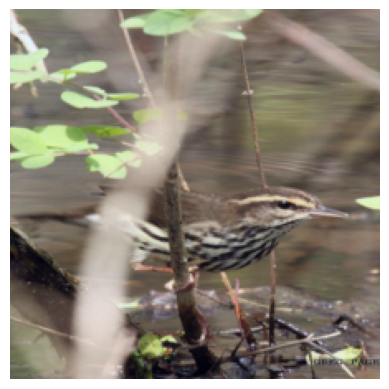

In [17]:
#@title KMEx baseline

import random

# base_path = 'drive/MyDrive/CoSegXAI/datasets/cub200/CUB_200_2011/CUB_200_2011/'
base_path = '/mnt/d/Github/SuperpixelCUB/CUB_200_data/CUB_200_2011/'

test_dataset = CUB(base_path, train=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=0)

random.seed(1033)
data_indices = random.sample(range(test_dataset.__len__()), 1)

for counter, data_idx in enumerate(data_indices):

  query, query_label, query_mask = test_dataset.__getitem__(data_idx)

plt.figure(1)
plt.imshow(imsc(query))
plt.axis('off')
plt.show()


query_clf_token = model(query.to('cuda').unsqueeze(0)).pooler_output
indices_of_k_closest_prototypes = get_k_closest_prototypes(model, query.to(device).unsqueeze(0), all_prototype_clf_tokens)
prototype_tokens, prototypes, prototype_labels, prototype_masks = get_prototype_tokens(indices_of_k_closest_prototypes, all_prototype_file_names, all_prototype_labels, model)
nn_clf_token = model(prototypes[0].to('cuda').unsqueeze(0)).pooler_output

class SimNetwork(nn.Module):
    def __init__(self, model, prototype):
        super().__init__()

        self.model = model
        self.prototype = prototype

    def forward(self, query):
        query_clf_token = model(query).pooler_output

        sim = nn.functional.cosine_similarity(query_clf_token, self.prototype).unsqueeze(0)

        return sim

2926
102
tensor(102)


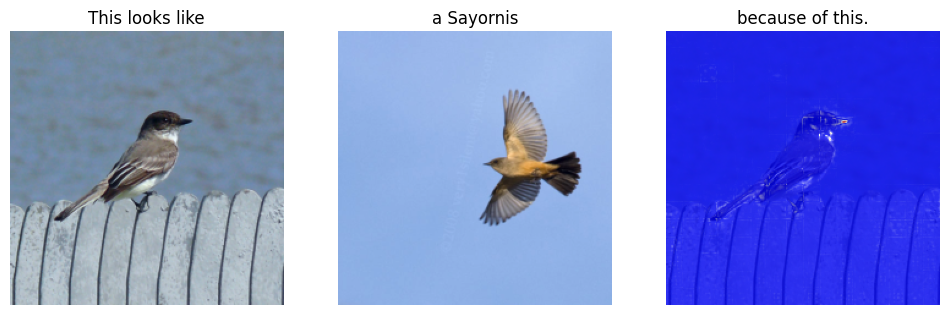

In [19]:
from captum.attr import Saliency, LRP, IntegratedGradients

random.seed(77777)
data_indices = random.sample(range(test_dataset.__len__()), 1)
#data_indices = [205]

for counter, data_idx in enumerate(data_indices):

  query, query_label, query_mask = test_dataset.__getitem__(data_idx)

query_clf_token = model(query.to('cuda').unsqueeze(0)).pooler_output
indices_of_k_closest_prototypes = get_k_closest_prototypes(model, query.to(device).unsqueeze(0), all_prototype_clf_tokens)
prototype_tokens, prototypes, prototype_labels, prototype_masks = get_prototype_tokens(indices_of_k_closest_prototypes, all_prototype_file_names, all_prototype_labels, model)
nn_clf_token = model(prototypes[0].to('cuda').unsqueeze(0)).pooler_output

net = SimNetwork(model, nn_clf_token)
saliency = Saliency(net)
ig = IntegratedGradients(net)
#attribution = saliency.attribute(query.to('cuda').unsqueeze(0), target=0).mean((0, 1))
attribution = torch.clamp(ig.attribute(query.to('cuda').unsqueeze(0), target=0, n_steps=10), min=0).mean((0, 1))

print(data_indices[0])
print(query_label)
print(prototype_labels[0])

plt.figure(1, figsize=(12, 4))
plt.subplot(131)
plt.imshow(imsc(query))
plt.title('This looks like')
plt.axis('off')
plt.subplot(132)
plt.imshow(imsc(prototypes[0]))
plt.title(f"a {class_names[query_label].split('.')[-1]}")
plt.axis('off')
plt.subplot(133)
plt.imshow(imsc(query))
plt.imshow(attribution.numpy(force=True), cmap='bwr', alpha=0.75)
plt.title('because of this.')
plt.axis('off')

plt.savefig(f"kmex_{data_indices[0]}_{np.int32(prototype_labels[0].item()==query_label)}.png", dpi=300)

In [26]:
from lxt.efficient import monkey_patch
from lxt.explicit.core import Composite
import lxt.explicit.rules as rules
from transformers import Dinov2Model
from torchvision.models import vision_transformer
from zennit.composites import LayerMapComposite
import zennit.rules as z_rules

class SimNetwork(nn.Module):
    def __init__(self, model, prototype):
        super().__init__()

        self.model = model
        self.prototype = prototype

    def forward(self, query):

        query_clf_token = self.model._process_input(query).mean(1)

        sim = nn.functional.cosine_similarity(query_clf_token, self.prototype).unsqueeze(0)

        return sim

random.seed(102)
data_indices = random.sample(range(test_dataset.__len__()), 1)

for counter, data_idx in enumerate(data_indices):

  query, query_label, query_mask = test_dataset.__getitem__(data_idx)

monkey_patch(vision_transformer, verbose=True)


vit = vision_transformer.vit_b_16(weights=vision_transformer.ViT_B_16_Weights.IMAGENET1K_V1).to('cuda')
vit.eval()

#model = Dinov2Model.from_pretrained("facebook/dinov2-base").to('cuda')

query_clf_token = model(query.to('cuda').unsqueeze(0))
indices_of_k_closest_prototypes = get_k_closest_prototypes(model, query.to(device).unsqueeze(0), all_prototype_clf_tokens)
prototype_tokens, prototypes, prototype_labels, prototype_masks = get_prototype_tokens(indices_of_k_closest_prototypes, all_prototype_file_names, all_prototype_labels, model)
nn_clf_token = vit._process_input(prototypes[0].to('cuda').unsqueeze(0)).mean(1)

# monkey_patch(SimNetwork, verbose=True)
net = SimNetwork(vit, nn_clf_token)

zennit_comp = LayerMapComposite([
    (torch.nn.Conv2d, z_rules.Gamma(0.1)),
    (torch.nn.Linear, z_rules.Gamma(0.0)),
])

zennit_comp.register(net)

query = query.to('cuda').unsqueeze(0).requires_grad_()
out = net(query)
# out = net(query.unsqueeze(0).to('cuda').requires_grad_())
out.backward()
heatmap = (query * query.grad).sum(1)

#saliency = Saliency(net)
#ig = IntegratedGradients(net)
#attribution = saliency.attribute(query.to('cuda').unsqueeze(0), target=0).mean((0, 1))
#attribution = ig.attribute(query.to('cuda').unsqueeze(0), target=0)


#plt.figure(1)
#plt.subplot(131)
#plt.imshow(imsc(query))
#plt.axis('off')
#plt.subplot(132)
#plt.imshow(imsc(prototypes[0]))
#plt.axis('off')
#plt.subplot(133)
#plt.imshow(attribution.numpy(force=True), cmap='bwr')
#plt.axis('off')
#plt.show()


/home/chensy/anaconda3/envs/vlpart_env/lib/python3.9/site-packages/lxt/efficient/patches.py:42: UserWarning: non_linear_forward already patched.
  warn(f"{target_fn.__name__} already patched.")
/home/chensy/anaconda3/envs/vlpart_env/lib/python3.9/site-packages/lxt/efficient/core.py:41: UserWarning: Failed to patch GELU. Skipping...
  warn(f"Failed to patch {target.__name__}. Skipping...")
/home/chensy/anaconda3/envs/vlpart_env/lib/python3.9/site-packages/lxt/efficient/patches.py:42: UserWarning: layer_norm_forward already patched.
  warn(f"{target_fn.__name__} already patched.")
/home/chensy/anaconda3/envs/vlpart_env/lib/python3.9/site-packages/lxt/efficient/core.py:41: UserWarning: Failed to patch LayerNorm. Skipping...
  warn(f"Failed to patch {target.__name__}. Skipping...")
/home/chensy/anaconda3/envs/vlpart_env/lib/python3.9/site-packages/lxt/efficient/patches.py:42: UserWarning: cp_multi_head_attention_forward already patched.
  warn(f"{target_fn.__name__} already patched.")
/hom

In [29]:
import torch
from zennit.composites import LayerMapComposite
import zennit.rules as z_rules

net.eval()
zennit_comp = LayerMapComposite([
    (torch.nn.Conv2d, z_rules.Gamma(0.1)),
    (torch.nn.Linear, z_rules.Gamma(0.0)),
])

    # Deactivate gradients on parameters to save memory
for param in net.parameters():
    param.requires_grad = False


zennit_comp.register(net)

out = net(query.unsqueeze(0).to('cuda').requires_grad_())
out.backward(retain_graph=True)
#out.backward(retain_graph=True)
#zennit_comp.remove()
#heatmap = (query * query.grad).sum(1)


ValueError: too many values to unpack (expected 4)

In [ ]:
query

In [23]:
def get_vit_imagenet(device="cuda"):
    """
    Load a pre-trained Vision Transformer (ViT) model with ImageNet weights.

    Parameters:
    device (str): Device to load the model on ('cuda' or 'cpu')

    Returns:
    tuple: (model, weights) - The ViT model and its pre-trained weights
    """
    weights =vision_transformer.ViT_B_16_Weights.IMAGENET1K_V1
    model = vision_transformer.vit_b_16(weights=weights)
    model.eval()
    model.to(device)

    # Deactivate gradients on parameters to save memory
    for param in model.parameters():
        param.requires_grad = False

    return model, weights

from torchvision.models import vision_transformer

test_model, weights = get_vit_imagenet()
input_tensor = weights.transforms()(query).unsqueeze(0).to("cuda")

zennit_comp = LayerMapComposite([
    (torch.nn.Conv2d, z_rules.Gamma(0.1)),
    (torch.nn.Linear, z_rules.Gamma(0.0)),
])

    # Register the composite rules with the model
zennit_comp.register(test_model)

y = test_model(input_tensor.requires_grad_())
print(y.shape)
y[0, 0].backward()
heatmap = (input_tensor * input_tensor.grad).sum(1)

torch.Size([1, 1000])


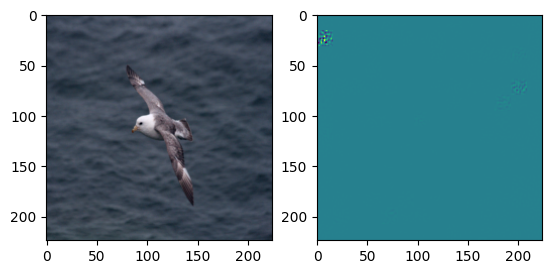

In [24]:
plt.figure(1)
plt.subplot(121)
plt.imshow(imsc(query))
plt.subplot(122)
plt.imshow(heatmap[0].numpy(force=True))